# Clustering Analysis of Uber NYC For-Hire Vehicle Trip Data (2021)

This notebook performs a clustering analysis on the Uber NYC for-hire vehicle trip data for the year 2021. The analysis integrates weather data and employs both K-Means and hierarchical clustering algorithms.

## Data Loading and Preparation

The first step involves loading the necessary datasets, including weather data, trip data, and taxi zone information.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=5e99c0a26c9be9a6ff2c946b0cd09fcc6e996eb30d259df33b3f43fbfe26a045
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
import pandas as pd
import pyarrow.parquet as pq
import geopandas as gpd
import os
from pyspark.sql import SparkSession
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Uber NYC Trip Data Analysis") \
    .getOrCreate()

# Load weather data
weather_data_path = 'Uber NYC for-hire vehicles trip data (2021)/nyc 2021-01-01 to 2021-12-31.csv'
weather_data = pd.read_csv(weather_data_path)

# Load trip data for January
trip_data_jan_path = 'Uber NYC for-hire vehicles trip data (2021)/fhvhv_tripdata_2021-01.parquet'
trip_data_jan = pq.read_table(trip_data_jan_path).to_pandas()

# Convert datetime columns to pandas datetime format
trip_data_jan['request_datetime'] = pd.to_datetime(trip_data_jan['request_datetime'])
trip_data_jan['pickup_datetime'] = pd.to_datetime(trip_data_jan['pickup_datetime'])
trip_data_jan['dropoff_datetime'] = pd.to_datetime(trip_data_jan['dropoff_datetime'])

# Load taxi zones shapefile
taxi_zones_shapefile_path = 'Uber NYC for-hire vehicles trip data (2021)/taxi_zones/taxi_zones.shp'
taxi_zones_shapefile = gpd.read_file(taxi_zones_shapefile_path)

# Load taxi zone lookup data
taxi_zones_lookup_path = 'Uber NYC for-hire vehicles trip data (2021)/taxi_zone_lookup.csv'
taxi_zones_lookup = pd.read_csv(taxi_zones_lookup_path)

# Merge trip data with taxi zone lookup to get zone names for pickup and drop-off locations
trip_data_jan = trip_data_jan.merge(taxi_zones_lookup, left_on='PULocationID', right_on='LocationID', suffixes=('', '_PU'))
trip_data_jan = trip_data_jan.merge(taxi_zones_lookup, left_on='DOLocationID', right_on='LocationID', suffixes=('', '_DO'))

# Preview the cleaned and merged data
print("Cleaned and Merged Trip Data - First Few Rows")
print(trip_data_jan.head())


Cleaned and Merged Trip Data - First Few Rows
  hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02682               B02682   
1            HV0005               B02510                 None   
2            HV0003               B02866               B02866   
3            HV0003               B02395               B02395   
4            HV0003               B02764               B02764   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2021-01-01 00:28:09 2021-01-01 00:31:42 2021-01-01 00:33:44   
1 2021-01-01 00:54:30                 NaT 2021-01-01 00:57:59   
2 2021-01-01 00:28:35 2021-01-01 00:28:50 2021-01-01 00:30:51   
3 2021-01-01 01:20:14 2021-01-01 01:27:41 2021-01-01 01:27:41   
4 2021-01-01 02:34:07 2021-01-01 02:38:45 2021-01-01 02:38:57   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
0 2021-01-01 00:49:07           230           166       5.260  ...   
1 2021-01-01 01:14:42           

## Data Integration

The weather data is merged with the trip data based on the pickup date to integrate the weather conditions with each trip.


In [4]:
# Extract date from pickup_datetime to merge with weather data
trip_data_jan['pickup_date'] = trip_data_jan['pickup_datetime'].dt.date

# Convert datetime in weather data to date
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data['date'] = weather_data['datetime'].dt.date

# Merge trip data with weather data
merged_data = pd.merge(trip_data_jan, weather_data, left_on='pickup_date', right_on='date', how='left')

# Preview the merged data
print("Merged Data - First Few Rows")
print(merged_data.head())

# Display information about the merged data
print("\nMerged Data Info")
print(merged_data.info())

# Display descriptive statistics of the merged data
print("\nMerged Data Description")
print(merged_data.describe())


Merged Data - First Few Rows
  hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02682               B02682   
1            HV0005               B02510                 None   
2            HV0003               B02866               B02866   
3            HV0003               B02395               B02395   
4            HV0003               B02764               B02764   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2021-01-01 00:28:09 2021-01-01 00:31:42 2021-01-01 00:33:44   
1 2021-01-01 00:54:30                 NaT 2021-01-01 00:57:59   
2 2021-01-01 00:28:35 2021-01-01 00:28:50 2021-01-01 00:30:51   
3 2021-01-01 01:20:14 2021-01-01 01:27:41 2021-01-01 01:27:41   
4 2021-01-01 02:34:07 2021-01-01 02:38:45 2021-01-01 02:38:57   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  snowdepth  \
0 2021-01-01 00:49:07           230           166       5.260  ...        0.0   
1 2021-01-01 01:14:42      

## MapReduce Analysis with PySpark

The analysis is performed using MapReduce in a true distributed processing environment using Apache Spark. The goal is to extract at least three interesting, non-trivial insights into the dataset.


In [8]:
from pyspark.sql.functions import col, avg, count
from pyspark import StorageLevel

# Initialize Spark session with increased memory
spark = SparkSession.builder \
    .appName("Uber NYC Trip Data Analysis") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

# Sample the data to a smaller fraction
sampled_for_spark = merged_data.sample(frac=0.8, random_state=42)

# Drop unnecessary columns to reduce size
columns_to_keep = ["Borough", "trip_miles", "base_passenger_fare", "pickup_date", "trip_time"]
sampled_for_spark = sampled_for_spark[columns_to_keep]

# Load the sampled data into Spark DataFrame
df_spark = spark.createDataFrame(sampled_for_spark)
df_spark.persist(StorageLevel.DISK_ONLY)

# 1. Average trip miles and base fare by Borough
average_trip_miles_fare = df_spark.groupBy("Borough").agg(
    avg("trip_miles").alias("average_trip_miles"),
    avg("base_passenger_fare").alias("average_base_passenger_fare")
)

# Show the result
average_trip_miles_fare.show()

# 2. Number of trips per day
trips_per_day = df_spark.groupBy("pickup_date").agg(count("*").alias("trips_count"))

# Show the result
trips_per_day.show()

# 3. Distribution of trip time by Borough
trip_time_distribution = df_spark.groupBy("Borough").agg(
    avg("trip_time").alias("average_trip_time")
)

# Show the result
trip_time_distribution.show()

# Stop the Spark session
spark.stop()


+-------------+------------------+---------------------------+
|      Borough|average_trip_miles|average_base_passenger_fare|
+-------------+------------------+---------------------------+
|       Queens|5.5972619437314455|         18.912061994793316|
|          EWR|20.080000000000002|         60.794444444444444|
|      Unknown| 7.222666666666666|                     16.657|
|     Brooklyn| 4.084381753593036|          16.65891356522375|
|Staten Island| 5.414945440466974|          17.23807969503843|
|    Manhattan| 4.386388320347181|         17.755120334968687|
|        Bronx| 4.319200539015133|          15.31355188508822|
+-------------+------------------+---------------------------+

+-----------+-----------+
|pickup_date|trips_count|
+-----------+-----------+
| 2021-01-27|      38749|
| 2021-01-18|      32670|
| 2021-01-25|      35612|
| 2021-01-05|      33612|
| 2021-01-19|      34440|
| 2021-01-24|      37930|
| 2021-01-22|      43980|
| 2021-01-23|      46183|
| 2021-01-09|      4

## Sampling the Data

To manage the large dataset effectively, a representative sample of the data will be used for clustering.


In [9]:
# Sample 1% of the data for clustering (using a separate sample from the Spark sample)
sampled_data_for_clustering = merged_data.sample(frac=0.01, random_state=42)

# Display information about the sampled data
print("\nSampled Data Info")
print(sampled_data_for_clustering.info())

# Display descriptive statistics of the sampled data
print("\nSampled Data Description")
print(sampled_data_for_clustering.describe())



Sampled Data Info
<class 'pandas.core.frame.DataFrame'>
Index: 119085 entries, 4117959 to 9473875
Data columns (total 55 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   hvfhs_license_num     119085 non-null  object        
 1   dispatching_base_num  119085 non-null  object        
 2   originating_base_num  87015 non-null   object        
 3   request_datetime      119085 non-null  datetime64[us]
 4   on_scene_datetime     87076 non-null   datetime64[us]
 5   pickup_datetime       119085 non-null  datetime64[us]
 6   dropoff_datetime      119085 non-null  datetime64[us]
 7   PULocationID          119085 non-null  int64         
 8   DOLocationID          119085 non-null  int64         
 9   trip_miles            119085 non-null  float64       
 10  trip_time             119085 non-null  int64         
 11  base_passenger_fare   119085 non-null  float64       
 12  tolls                 119085 non-null

## Feature Selection and Normalization

Relevant features for clustering are selected, and any missing values are filled with the mean. The features are then normalized.


In [10]:
from sklearn.preprocessing import StandardScaler

# Selecting features for clustering
features = sampled_data_for_clustering[['trip_miles', 'trip_time', 'base_passenger_fare', 'temp', 'humidity']]

# Filling any missing values with the mean of the column
features = features.fillna(features.mean())

# Normalizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


## K-Means Clustering

K-Means clustering is applied to the normalized features, and the resulting clusters are visualized.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


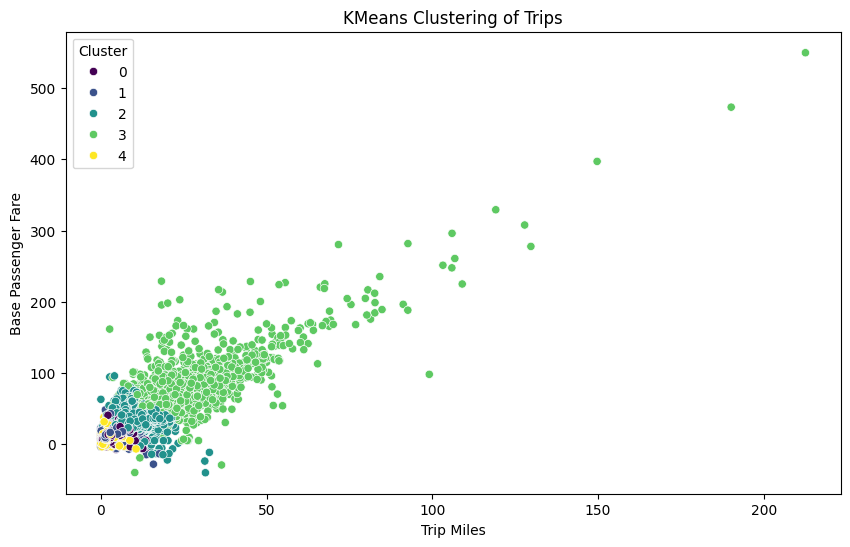

In [11]:
from sklearn.cluster import KMeans

# Performing KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(features_scaled)

# Adding cluster labels to the data
sampled_data_for_clustering['cluster_kmeans'] = clusters_kmeans

# Visualizing the KMeans clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sampled_data_for_clustering['trip_miles'], y=sampled_data_for_clustering['base_passenger_fare'], hue=clusters_kmeans, palette='viridis')
plt.xlabel('Trip Miles')
plt.ylabel('Base Passenger Fare')
plt.title('KMeans Clustering of Trips')
plt.legend(title='Cluster')
plt.show()


## Hierarchical Clustering

Hierarchical clustering is performed using the Ward method, and the clusters are visualized using a dendrogram and scatter plot.


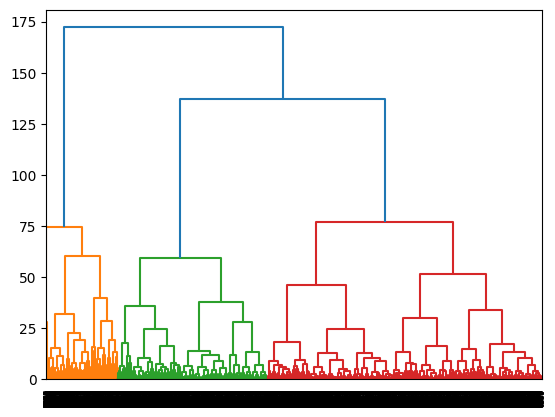

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Performing hierarchical clustering on a smaller subset to avoid memory issues
subset_data = features_scaled[:10000]

# Performing hierarchical clustering
linkage_matrix = linkage(subset_data, method='ward')
dendro = dendrogram(linkage_matrix)

# Adding hierarchical clustering labels to the data
clusters_hierarchical = fcluster(linkage_matrix, 5, criterion='maxclust')
sampled_data_for_clustering['cluster_hierarchical'] = None
sampled_data_for_clustering.loc[sampled_data_for_clustering.index[:10000], 'cluster_hierarchical'] = clusters_hierarchical

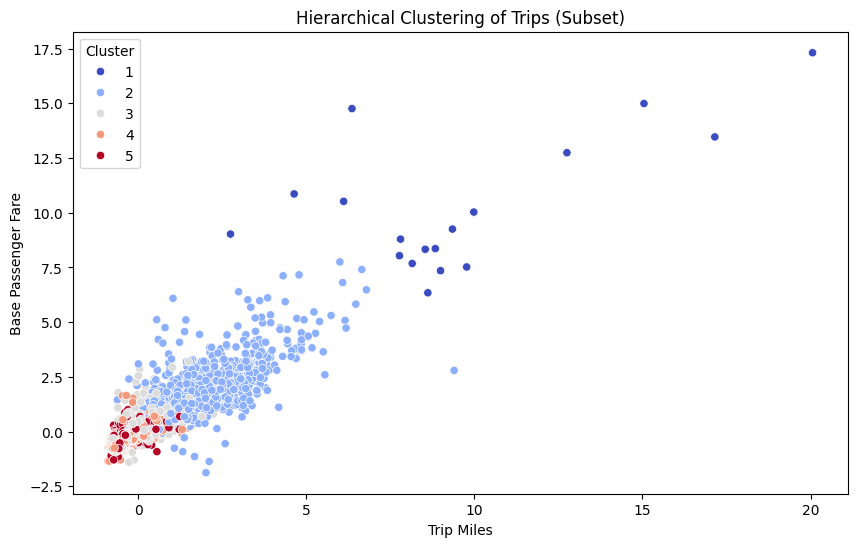

In [14]:
# Visualizing the hierarchical clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=subset_data[:, 0], y=subset_data[:, 2], hue=clusters_hierarchical, palette='coolwarm')
plt.xlabel('Trip Miles')
plt.ylabel('Base Passenger Fare')
plt.title('Hierarchical Clustering of Trips (Subset)')
plt.legend(title='Cluster')
plt.show()

## Saving the Merged Data

The merged data with cluster labels is saved for further analysis and reporting.


In [ ]:
# Save the merged data for further analysis and reporting
merged_data.to_csv('merged_trip_weather_data.csv', index=False)


## Exploratory Data Analysis (EDA)

The following visualizations will help in understanding the distribution and relationships in the merged dataset.


In [15]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Set the style for the plots
sns.set(style="whitegrid")


### Distribution of Trip Miles

This histogram shows the distribution of trip miles.


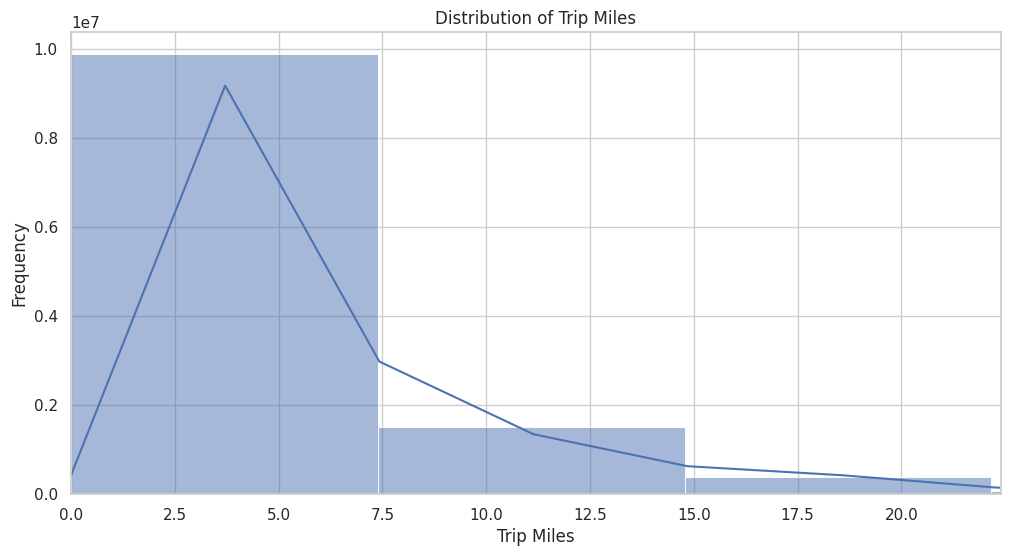

In [16]:
# Distribution of Trip Miles
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['trip_miles'], kde=True, bins=100)
plt.title('Distribution of Trip Miles')
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.xlim(0, merged_data['trip_miles'].quantile(0.99))
plt.show()


### Distribution of Base Passenger Fare

This histogram shows the distribution of base passenger fare.


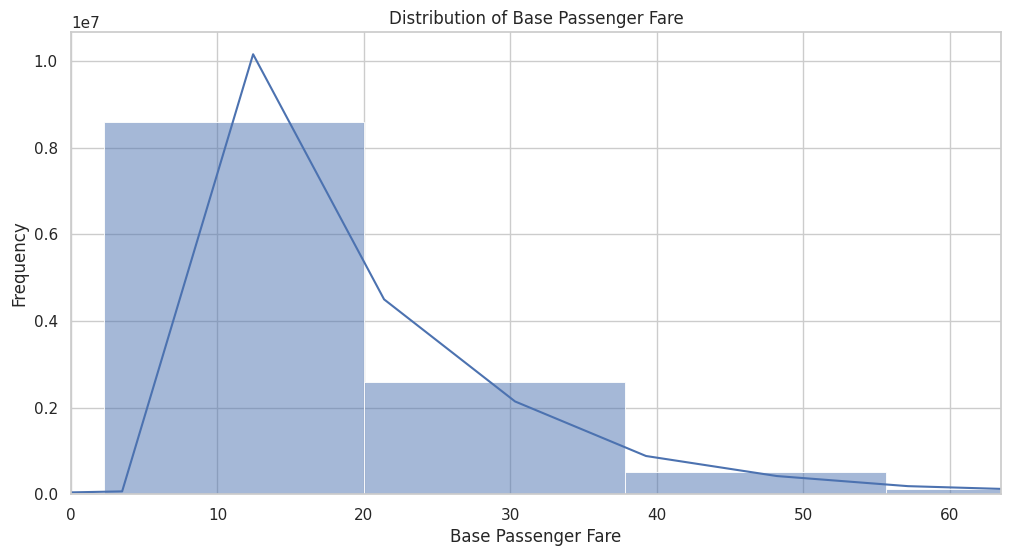

In [17]:
# Distribution of Base Passenger Fare
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['base_passenger_fare'], kde=True, bins=100)
plt.title('Distribution of Base Passenger Fare')
plt.xlabel('Base Passenger Fare')
plt.ylabel('Frequency')
plt.xlim(0, merged_data['base_passenger_fare'].quantile(0.99))
plt.show()


### Trip Miles vs. Base Passenger Fare

A scatter plot to observe the relationship between trip miles and base passenger fare.


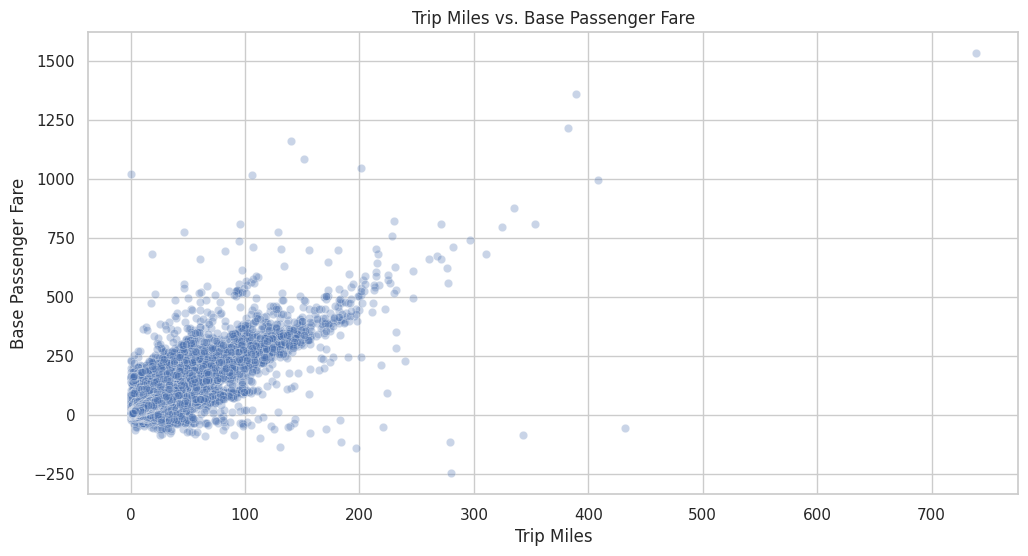

In [18]:
# Scatter plot of Trip Miles vs. Base Passenger Fare
plt.figure(figsize=(12, 6))
sns.scatterplot(x='trip_miles', y='base_passenger_fare', data=merged_data, alpha=0.3)
plt.title('Trip Miles vs. Base Passenger Fare')
plt.xlabel('Trip Miles')
plt.ylabel('Base Passenger Fare')
plt.show()


### Distribution of Trip Time

This histogram shows the distribution of trip time in seconds.


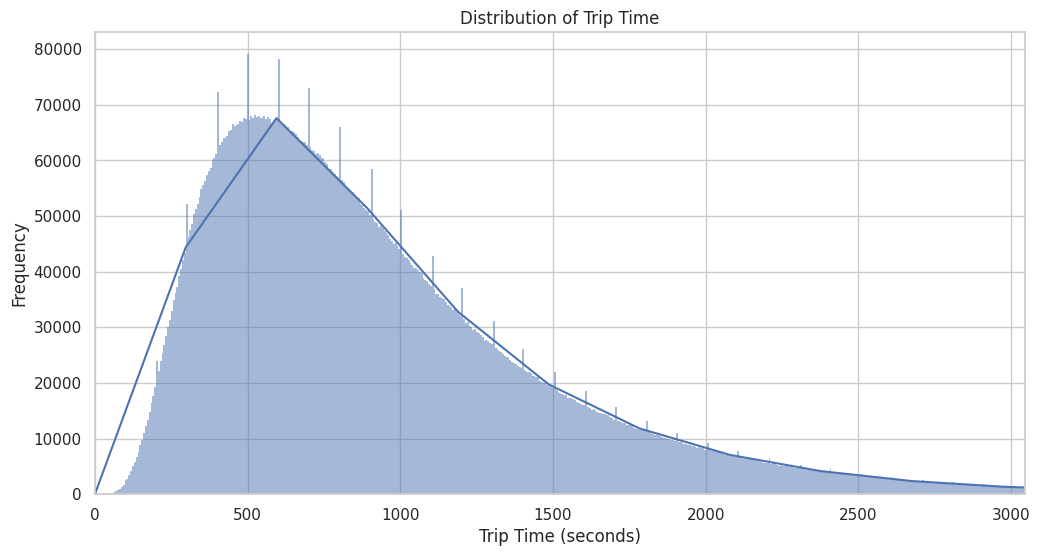

In [19]:
# Distribution of Trip Time
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['trip_time'], kde=True)
plt.title('Distribution of Trip Time')
plt.xlabel('Trip Time (seconds)')
plt.ylabel('Frequency')
plt.xlim(0, merged_data['trip_time'].quantile(0.99))
plt.show()


### Trip Miles by Borough

A box plot to compare the distribution of trip miles across different boroughs.


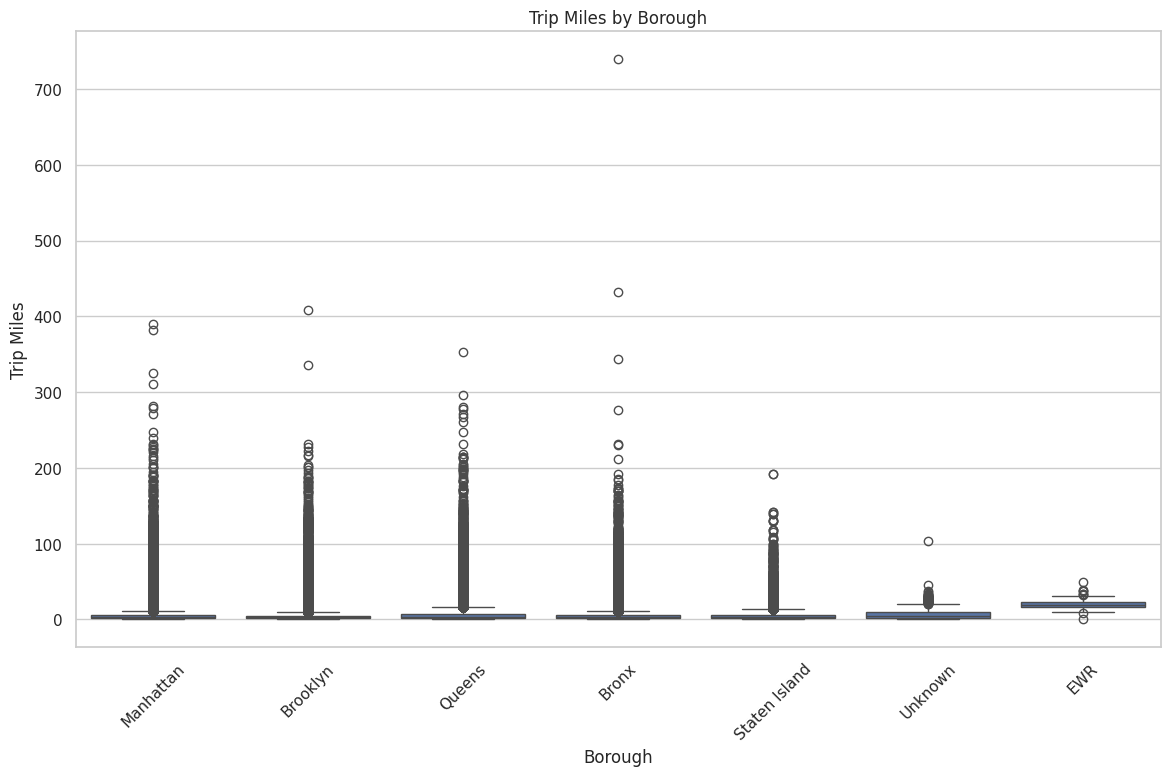

In [20]:
# Box plot of Trip Miles by Borough
plt.figure(figsize=(14, 8))
sns.boxplot(x='Borough', y='trip_miles', data=merged_data)
plt.title('Trip Miles by Borough')
plt.xlabel('Borough')
plt.ylabel('Trip Miles')
plt.xticks(rotation=45)
plt.show()


### Base Passenger Fare by Borough

A box plot to compare the distribution of base passenger fare across different boroughs.


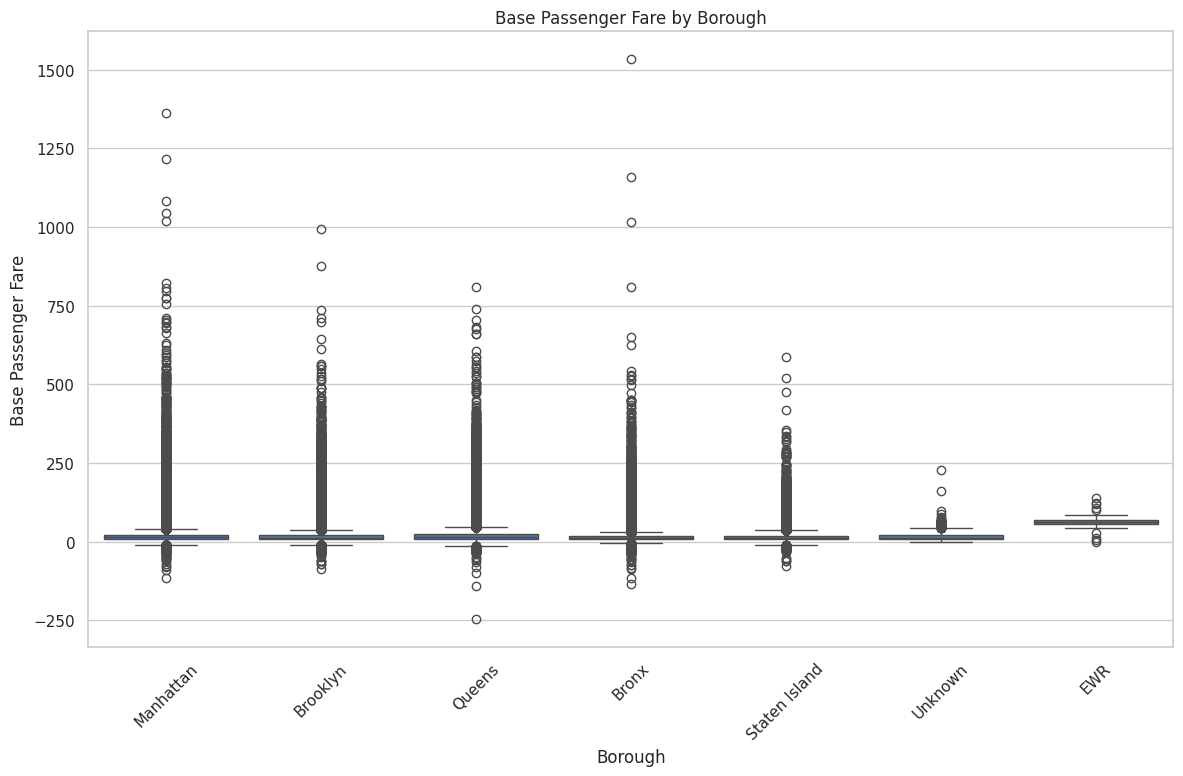

In [21]:
# Box plot of Base Passenger Fare by Borough
plt.figure(figsize=(14, 8))
sns.boxplot(x='Borough', y='base_passenger_fare', data=merged_data)
plt.title('Base Passenger Fare by Borough')
plt.xlabel('Borough')
plt.ylabel('Base Passenger Fare')
plt.xticks(rotation=45)
plt.show()


### Trip Miles vs. Temperature

A scatter plot to observe the relationship between trip miles and temperature.


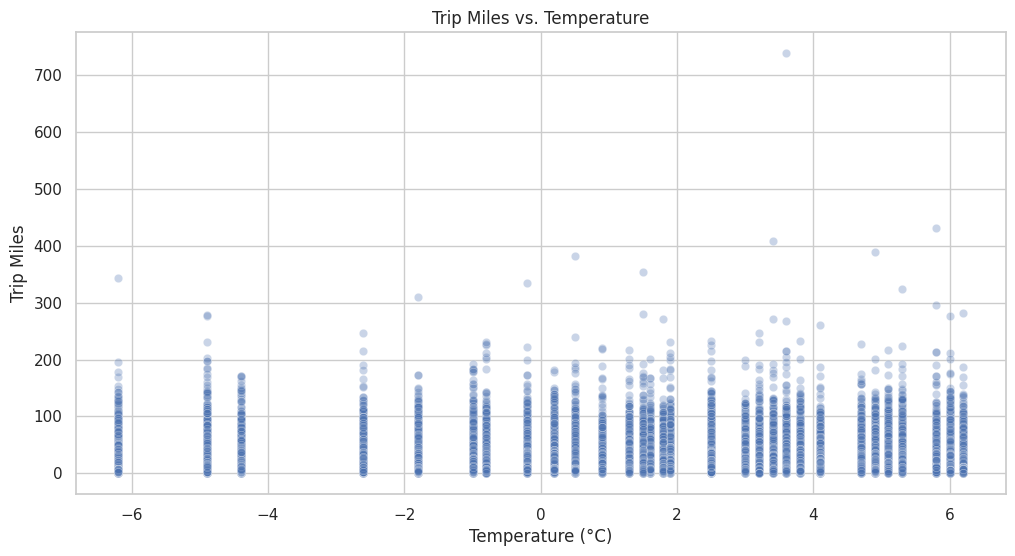

In [22]:
# Scatter plot of Trip Miles vs. Temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temp', y='trip_miles', data=merged_data, alpha=0.3)
plt.title('Trip Miles vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Trip Miles')
plt.show()


### Trip Miles vs. Humidity

A scatter plot to observe the relationship between trip miles and humidity.


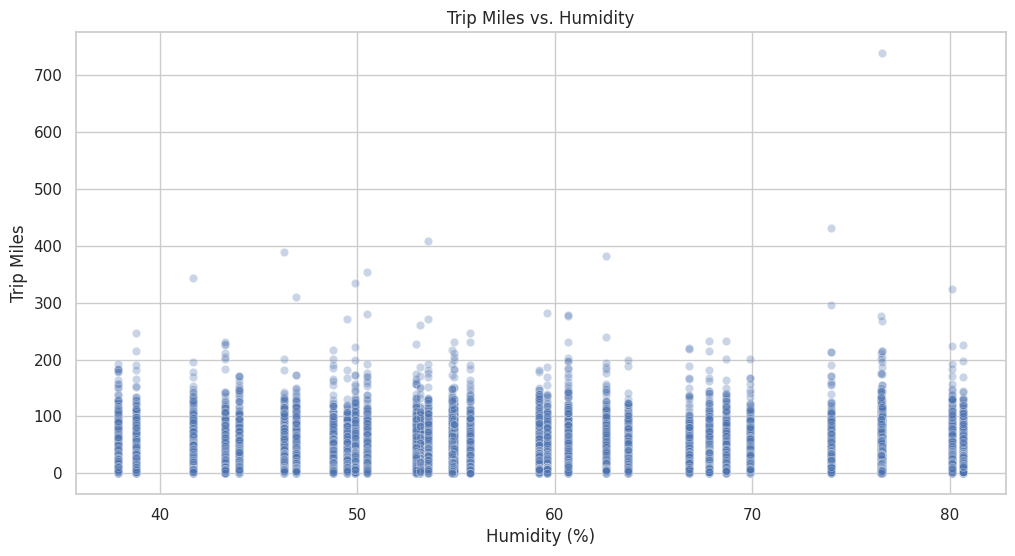

In [23]:
# Scatter plot of Trip Miles vs. Humidity
plt.figure(figsize=(12, 6))
sns.scatterplot(x='humidity', y='trip_miles', data=merged_data, alpha=0.3)
plt.title('Trip Miles vs. Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Trip Miles')
plt.show()
